# The inevitable MNIST data set & classification

In [1]:
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
X, y = mnist.data, mnist.target

In [5]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
# Let's see what an instance in this data set look like
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


(-0.5, 27.5, 27.5, -0.5)

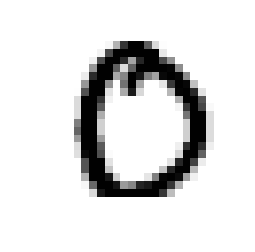

In [7]:
some_random_digit = X[11]
some_random_digit_image = some_random_digit.reshape(28,28)
plt.imshow(some_random_digit_image, interpolation = 'nearest', cmap = matplotlib.cm.binary )
plt.axis('off')

In [8]:
# Looks like a Zero. let's see what is in the target
y[11]

0.0

In [9]:
# Since the data is already broken in train and test 
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Let's Train a bianry classifier for fun!

## Hotdog/ not hotdog (ref. Silicon Valley)
 0 or not

In [11]:
y_train_0 = (y_train == 0)
y_test_0 = (y_test == 0)

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_classifier =  SGDClassifier()

In [13]:
sgd_classifier.fit(X_train, y_train_0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [14]:
sgd_classifier.predict([some_random_digit])

array([ True], dtype=bool)

In [15]:
sgd_classifier.score(X_test, y_test_0)

0.99019999999999997

In [16]:
sgd_classifier.score(X_train, y_train_0)

0.98866666666666669

Let's See what the cross-validation scores are

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier,X_train, y_train_0, cv =3 , scoring = "accuracy" )

array([ 0.98380081,  0.98845   ,  0.9539977 ])

This looks promising. But, let's train a dumb classifier which predicts that there isn't any zero

In [18]:
from sklearn.base import BaseEstimator
class Never0Classifier(BaseEstimator):
    def fit (self, X, y= None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_0 = Never0Classifier()
cross_val_score(never_0 ,X_train, y_train_0, cv =3 , scoring = "accuracy" )

array([ 0.9021 ,  0.89925,  0.9025 ])

Not much different! Actually, Accuracy is not a good measure for skewed dataset.

## Confusion Matrix

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_0, cv =3)

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_0,y_train_pred )

array([[53533,   544],
       [  284,  5639]])

In [22]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score

In [23]:
print('accuracy_score',accuracy_score(y_train_0,y_train_pred))
print('precision_score',precision_score(y_train_0,y_train_pred))
print('f1_score',f1_score(y_train_0,y_train_pred))
print('recall_score',recall_score(y_train_0,y_train_pred) )

accuracy_score 0.9862
precision_score 0.912016820314
f1_score 0.931604163225
recall_score 0.952051325342


## Precision/Recall Curve

In [24]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_0, cv =3, method='decision_function')

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_0,y_scores)

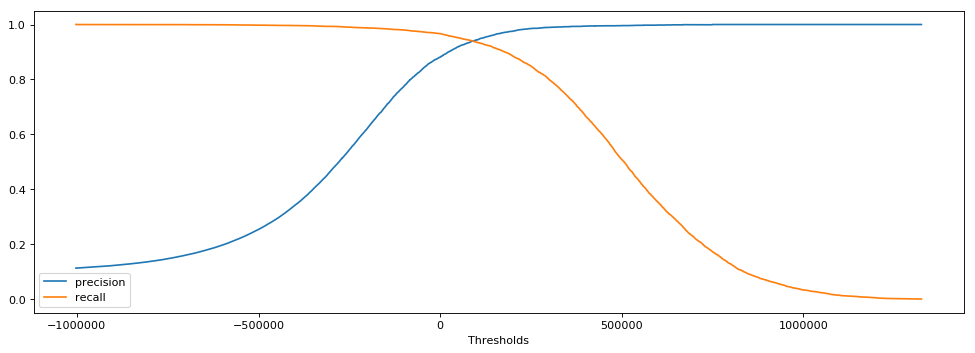

In [26]:
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(thresholds, precisions[:-1], label = 'precision')
plt.plot(thresholds, recalls[:-1], label = 'recall')
plt.xlabel('Thresholds')

plt.legend()

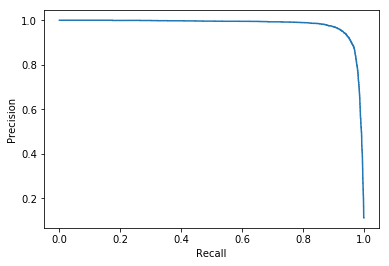

In [27]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')


In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_0,y_scores)

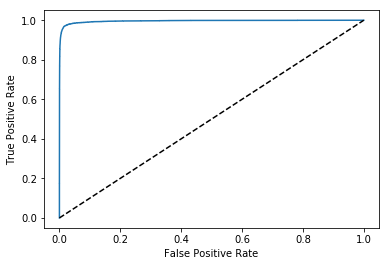

In [29]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1], 'k--')


In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_classifier = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_classifier, X_train, y_train_0, cv =3, method='predict_proba')

In [31]:
y_prob_score = y_probas_forest[:,1]

In [32]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_0, y_prob_score)

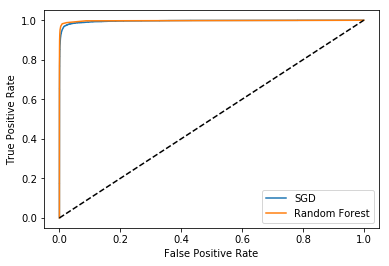

In [33]:
plt.plot(fpr, tpr, label = 'SGD')
plt.plot(fpr_forest, tpr_forest,  label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1], 'k--')
plt.legend()

Not much Different!

## Multiclass classification

In [35]:
sgd_classifier.fit(X_train, y_train)
sgd_classifier.predict([some_random_digit])

array([ 0.])

In [36]:
sgd_classifier.decision_function([some_random_digit])

array([[ 176415.00052103, -774107.55386899, -175431.76958067,
        -269354.9045575 , -570939.35583557, -658717.23886848,
        -775866.36641339, -503580.40930032, -271244.58815398,
        -584930.12876945]])

In [37]:
forest_classifier.fit(X_train, y_train)
forest_classifier.predict([some_random_digit])

array([ 0.])

In [38]:
forest_classifier.predict_proba([some_random_digit])

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## Error Analysis

In [39]:
y_pred_multi = cross_val_predict(sgd_classifier, X_train, y_train, cv =3)

In [40]:
confusion_matrix(y_train,y_pred_multi )

array([[5644,    0,   27,   13,    7,   61,   53,    8,  105,    5],
       [   1, 6517,   44,    8,    4,   33,    8,    7,  105,   15],
       [  60,   76, 5177,   78,   82,   47,  118,   58,  241,   21],
       [  48,   48,  229, 4846,   13,  403,   30,   50,  328,  136],
       [  19,   37,   69,   23, 4812,   68,   99,   48,  309,  358],
       [  97,   36,   46,  270,   46, 4170,  199,   21,  457,   79],
       [  33,   29,   75,    5,   24,  252, 5368,    5,  125,    2],
       [  34,   49,   94,   29,   37,   83,   11, 5423,   54,  451],
       [  59,  196,  104,   95,   28,  540,   64,   19, 4615,  131],
       [  43,   35,   42,   56,  144,  192,   10,  144,  151, 5132]])

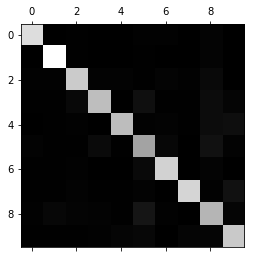

In [41]:
plt.matshow(confusion_matrix(y_train,y_pred_multi ), cmap = plt.cm.gray)

We see that the classifier is doing a decent job, except for few cases like 3 which is getting confused by 8 and 5 similarly 7 and 9 are getting mixed up.

## Multioutput multilclass Classification

Let's use Multioutput multiclass classification to remove noise from an image

In [42]:
# let's start by creating training and test data from MNIST data 
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [45]:
28*28

784

(-0.5, 27.5, 27.5, -0.5)

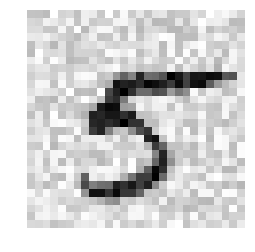

In [51]:
some_index = 5500
a = X_test_mod[some_index].reshape(-28,28)
plt.imshow(a, interpolation = 'nearest', cmap = matplotlib.cm.binary )
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

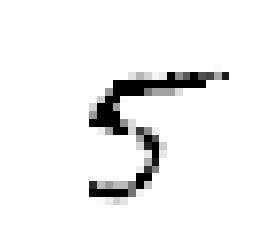

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
b = clean_digit.reshape(-28,28)
plt.imshow(b, interpolation = 'nearest', cmap = matplotlib.cm.binary )
plt.axis('off')